In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pywt
import os
import sys
from importlib import reload
from pyedflib import highlevel
from scipy.signal import butter, lfilter

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Подгружаем пути к директориям с нашими алгоритмами:
script_path = os.path.join(os.getcwd(), "../../Scripts/")
sys.path.append(script_path)
import data_generator as dgen
import features as ft


In [2]:
dgen.init(filter=True)
amy, amyc, norm, amy_h, amyc_h, norm_h = dgen.read_data_with_meta()

In [3]:
norm_parts = dgen.crop(norm)
amy_parts = dgen.crop(amy)
amyc_parts = dgen.crop(amyc)

Изучим общее количество фрагментов для каждого класса

In [4]:
print(len(norm_parts), "- Norm parts")
print(len(amy_parts), "- amy parts")
print(len(amyc_parts), "- amyc parts")

norm_parts = np.array(norm_parts)
amy_parts = np.array(amy_parts)
amyc_parts = np.array(amyc_parts)

0 - Norm parts
0 - amy parts
0 - amyc parts


In [5]:
def extract_statistical_features(ecg_signal):
    features = {}
    features['std'] = pd.Series(np.std(ecg_signal, axis=1))
    features['min'] = pd.Series(np.min(ecg_signal, axis=1))
    features['max'] = pd.Series(np.max(ecg_signal, axis=1))
    features['range'] = pd.Series(np.ptp(ecg_signal, axis=1))  # max - min
    return features

def extract_frequency_features(ecg_signal):
    # Преобразование Фурье
    fft = np.fft.fft(ecg_signal)
    fft_mag = np.abs(fft)
    
    # Извлекаем частотные признаки
    features = {}
    features['freq_std'] = pd.Series(np.std(fft_mag, axis=1))
    features['freq_max'] = pd.Series(np.max(fft_mag, axis=1))
    
    return features

def extract_wavelet_features(ecg_signal):
    coeffs = pywt.wavedec(ecg_signal, 'db4', level=4)
    features = {}
    
    # Извлечение статистики для каждого уровня
    for i, coeff in enumerate(coeffs):
        features[f'wavelet_std_level_{i}'] = pd.Series(np.std(coeff, axis=1))
    
    return features


А теперь поделим данные на трейн тест по людям, и после порежем сигналы на части

In [6]:
data_raw = norm + amyc + amy
data_raw = [row[0] for row in data_raw]
#data_raw = norm + amy
lab = np.concatenate([np.zeros(len(norm) + len(amyc)), np.ones(len(amy))])
#lab = np.concatenate([np.zeros(len(norm)), np.ones(len(amy))])
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(data_raw, lab, test_size=0.2, random_state=42)

data_train = []
y_train = []
data_test = []
y_test = []

for i in range(len(X_train_raw)):
    temp = dgen.crop([X_train_raw[i]])
    data_train.extend(temp)
    y_train.extend(y_train_raw[i] * np.ones(len(temp)))

for i in range(len(X_test_raw)):
    temp = dgen.crop([X_test_raw[i]])
    data_test.extend(temp)
    y_test.extend(y_test_raw[i] * np.ones(len(temp)))

data_train = np.array(data_train)
y_train = np.array(y_train)
data_test = np.array(data_test)
y_test = np.array(y_test)


In [7]:
X_train = pd.DataFrame({**extract_statistical_features(data_train), **extract_frequency_features(data_train), **extract_wavelet_features(data_train)})
X_test = pd.DataFrame({**extract_statistical_features(data_test), **extract_frequency_features(data_test), **extract_wavelet_features(data_test)})

# Классификатор Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Оценка точности
y_pred = rf.predict(X_test)
print(f"Random Forest accuracy: {accuracy_score(y_test, y_pred)}")

# Классификатор SVM
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print(f"SVM accuracy: {accuracy_score(y_test, y_pred_svm)}")

Random Forest accuracy: 0.6475409836065574
SVM accuracy: 0.569672131147541


In [8]:
X_train.head()

,std,min,max,range,freq_std,freq_max,wavelet_std_level_0,wavelet_std_level_1,wavelet_std_level_2,wavelet_std_level_3,wavelet_std_level_4
0,0.091085,-0.325233,0.318629,0.643862,2.328467,24.943050,0.486435,0.080551,0.031369,0.009114,0.000902
1,0.089911,-0.216934,0.316542,0.533476,2.338530,26.204247,0.338564,0.106406,0.032119,0.008764,0.000857
2,0.079856,-0.217852,0.267483,0.485335,2.060415,16.689301,0.284838,0.121240,0.035835,0.008147,0.000898
3,0.055785,-0.176306,0.262538,0.438844,1.435022,13.389302,0.301791,0.048756,0.029163,0.008469,0.000851
4,0.093429,-0.261843,0.304535,0.566378,2.374293,20.766635,0.396195,0.104799,0.047392,0.010523,0.000932


Простая важность

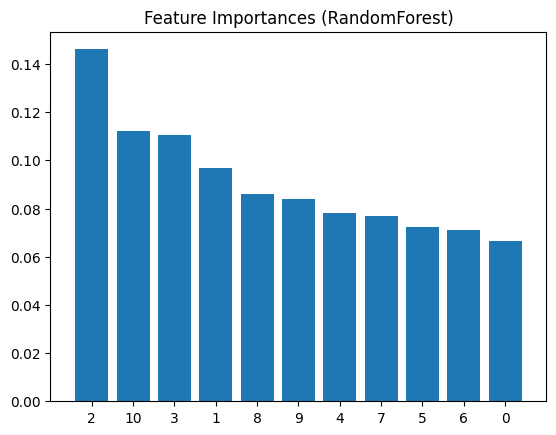

Feature 2: 0.14608385646494187
Feature 10: 0.11196773863881815
Feature 3: 0.11047615005872462
Feature 1: 0.09663061443883152
Feature 8: 0.08612062504801526
Feature 9: 0.08409038851060893
Feature 4: 0.07808576161456719
Feature 7: 0.07668731346131644
Feature 5: 0.0723205777521442
Feature 6: 0.07103401136493413
Feature 0: 0.06650296264709774


In [9]:
# Получение важности признаков
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Визуализация важности признаков
plt.figure()
plt.title("Feature Importances (RandomForest)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Вывод важности признаков
for i in range(X_train.shape[1]):
    print(f"Feature {indices[i]}: {importances[indices[i]]}")

Permutation importance

In [10]:
from sklearn.inspection import permutation_importance

# Оценка перестановочной важности признаков
perm_importance = permutation_importance(rf, X_train, y_train, n_repeats=100, random_state=42)

# Получение важности и сортировка
indices = np.argsort(perm_importance.importances_mean)[::-1]

# Вывод важности признаков
for i in range(X_train.shape[1]):
    print(f"Feature {indices[i]}: {perm_importance.importances_mean[indices[i]]}")

Feature 2: 0.11531893004115228
Feature 10: 0.046985596707818926
Feature 3: 0.04574074074074074
Feature 8: 0.02749999999999999
Feature 7: 0.025246913580246905
Feature 1: 0.021893004115226333
Feature 9: 0.010864197530864206
Feature 5: 0.008446502057613166
Feature 4: 0.006790123456790118
Feature 6: 0.005380658436213982
Feature 0: 0.0017489711934156405


SHAP Values (SHapley Additive exPlanations)

/home/artemka/Projects/Diplomas/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(972, 11)


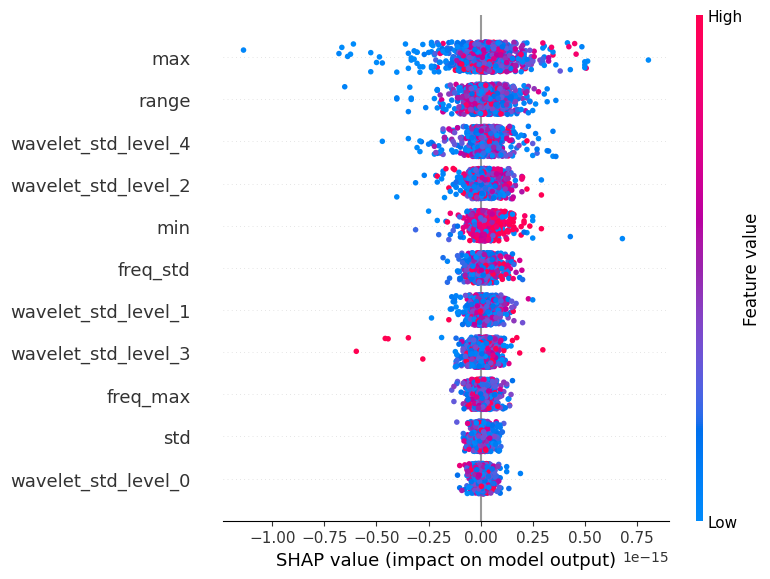

In [11]:
import shap 
# Создание объекта SHAP explainer
explainer = shap.TreeExplainer(rf)

# Получение SHAP values
shap_values = explainer.shap_values(X_train)


# Визуализация важности признаков
# shap.summary_plot(shap_values, X_train, plot_size=(12, 8))
# Для бинарной классификации можно усреднить SHAP values
mean_shap_values = np.mean(shap_values, axis=2)
print(mean_shap_values.shape)
shap.summary_plot(mean_shap_values, X_train)

Voting accuracy: 0.6270491803278688

 clasification report:
               precision    recall  f1-score   support

         0.0       0.61      0.96      0.75       140
         1.0       0.76      0.18      0.29       104

    accuracy                           0.63       244
   macro avg       0.69      0.57      0.52       244
weighted avg       0.68      0.63      0.55       244

Матрица несоответствий для тестовой выборки метода ЛДА:



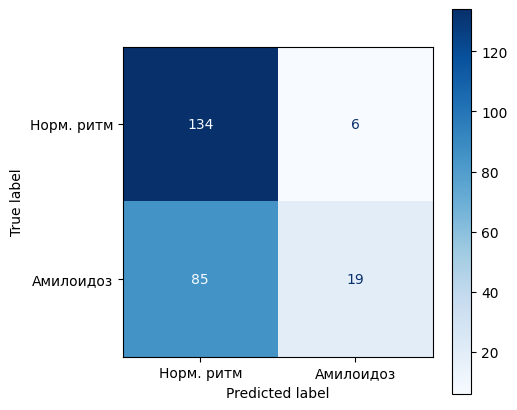

In [12]:
# Создание нескольких классификаторов
rf = RandomForestClassifier(criterion='log_loss')
svm = SVC(probability=True)
# Добавим классификаторы в ансамбль
voting_clf = VotingClassifier(estimators=[('rf', rf), ('svm', svm)], voting='soft')

# Обучение ансамбля
voting_clf.fit(X_train, y_train)

# Оценка точности
y_pred_voting = voting_clf.predict(X_test)
print(f"Voting accuracy: {accuracy_score(y_test, y_pred_voting)}")

# Замените названия классов на соответствующие вам
class_names = ['Норм. ритм', 'Амилоидоз']

print ('\n clasification report:\n', classification_report(y_test, y_pred_voting))

print('Матрица несоответствий для тестовой выборки метода ЛДА:\n')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_voting), display_labels= class_names)
disp.plot(cmap = 'Blues', ax=ax)


# Пробуем с готовыми фичами Зины



In [15]:
import pickle
with open('../../Data/dumped/X_train.pkl', 'rb') as f:
    f.seek(0)
    X_train = pickle.load(f)
with open('../../Data/dumped/y_train.pkl', 'rb') as f:
    f.seek(0)
    y_train = pickle.load(f)
with open('../../Data/dumped/X_test.pkl', 'rb') as f:
    f.seek(0)
    X_test = pickle.load(f)
with open('../../Data/dumped/y_test.pkl', 'rb') as f:
    f.seek(0)
    y_test = pickle.load(f)

features_train = ft.extract_features(X_train, y_train[1])
features_train = features_train.fillna(0)

features_test = ft.extract_features(X_test, y_test[1])
features_test = features_test.fillna(0)

X_train = features_train
X_test =features_test
y_train = y_train[0]
y_test = y_test[0]


# Классификатор Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Оценка точности
y_pred = rf.predict(X_test)
print(f"Random Forest accuracy: {accuracy_score(y_test, y_pred)}")

# Классификатор SVM
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print(f"SVM accuracy: {accuracy_score(y_test, y_pred_svm)}")

/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../../Scripts/features.py:156: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(mean_qrs, mean_t) / (np.linalg.norm(mean_qrs) * np.linalg.norm(mean_t))
/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../../Scripts/features.py:156: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(mean_qrs, mean_t) / (np.linalg.norm(mean_qrs) * np.linalg.norm(mean_t))
/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../../Scripts/features.py:156: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(mean_qrs, mean_t) / (np.linalg.norm(mean_qrs) * np.linalg.norm(mean_t))
/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../../Scripts/features.py:156: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(mean_qrs, mean_t) / (np.linalg.norm(mean_qrs) * np.linalg.norm(mean_t))
/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../

Ошибка при обработке сигнала 33: cannot do slice indexing on RangeIndex with these indexers [nan] of type float
Ошибка при обработке сигнала 34: cannot do slice indexing on RangeIndex with these indexers [nan] of type float


/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../../Scripts/features.py:156: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(mean_qrs, mean_t) / (np.linalg.norm(mean_qrs) * np.linalg.norm(mean_t))
/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../../Scripts/features.py:156: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(mean_qrs, mean_t) / (np.linalg.norm(mean_qrs) * np.linalg.norm(mean_t))


Ошибка при обработке сигнала 36: cannot do slice indexing on RangeIndex with these indexers [nan] of type float


/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../../Scripts/features.py:156: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(mean_qrs, mean_t) / (np.linalg.norm(mean_qrs) * np.linalg.norm(mean_t))
/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../../Scripts/features.py:156: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(mean_qrs, mean_t) / (np.linalg.norm(mean_qrs) * np.linalg.norm(mean_t))
/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../../Scripts/features.py:156: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(mean_qrs, mean_t) / (np.linalg.norm(mean_qrs) * np.linalg.norm(mean_t))
/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../../Scripts/features.py:156: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(mean_qrs, mean_t) / (np.linalg.norm(mean_qrs) * np.linalg.norm(mean_t))
/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../

Ошибка при обработке сигнала 55: cannot do slice indexing on RangeIndex with these indexers [nan] of type float


/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../../Scripts/features.py:156: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(mean_qrs, mean_t) / (np.linalg.norm(mean_qrs) * np.linalg.norm(mean_t))
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7402b443e6c0>>
Traceback (most recent call last):
  File "/home/artemka/Projects/Diplomas/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../../Scripts/features.py:156: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(mean_qrs, mean_t) / (np.linalg.norm(mean_qrs) * np.linalg.norm(mean_t))
/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../../Scripts/features.py:156: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta

Ошибка при обработке сигнала 111: cannot do slice indexing on RangeIndex with these indexers [nan] of type float


/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../../Scripts/features.py:156: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(mean_qrs, mean_t) / (np.linalg.norm(mean_qrs) * np.linalg.norm(mean_t))
/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../../Scripts/features.py:156: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(mean_qrs, mean_t) / (np.linalg.norm(mean_qrs) * np.linalg.norm(mean_t))
/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../../Scripts/features.py:156: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(mean_qrs, mean_t) / (np.linalg.norm(mean_qrs) * np.linalg.norm(mean_t))
/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../../Scripts/features.py:156: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(mean_qrs, mean_t) / (np.linalg.norm(mean_qrs) * np.linalg.norm(mean_t))
/home/artemka/Projects/Diplomas/Classifiers/RF + SVM/../

ValueError: Found input variables with inconsistent numbers of samples: [175, 180]

(180, 12)


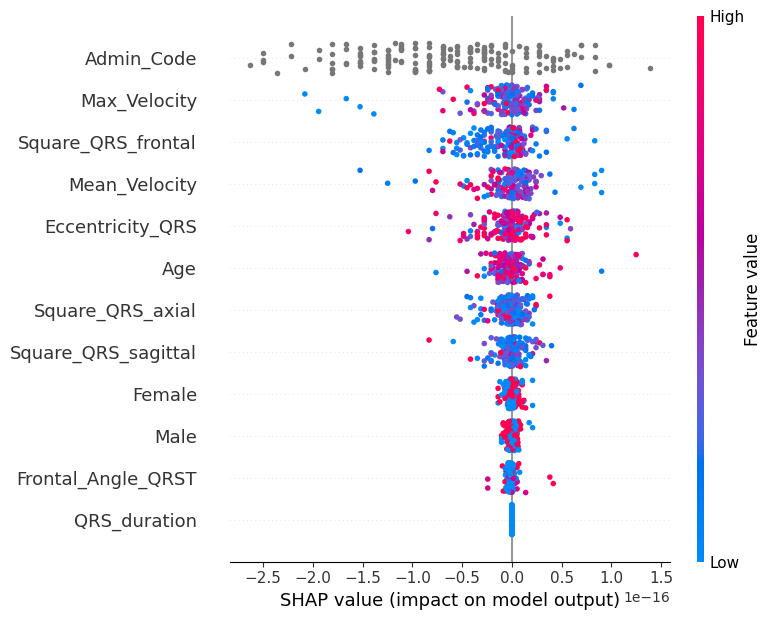

In [14]:
import shap 
# Создание объекта SHAP explainer
explainer = shap.TreeExplainer(rf)

# Получение SHAP values
shap_values = explainer.shap_values(X_train)


# Визуализация важности признаков
# shap.summary_plot(shap_values, X_train, plot_size=(12, 8))
# Для бинарной классификации можно усреднить SHAP values
mean_shap_values = np.mean(shap_values, axis=2)
print(mean_shap_values.shape)
shap.summary_plot(mean_shap_values, features_train)

Voting accuracy: 0.7391304347826086

 clasification report:
               precision    recall  f1-score   support

         0.0       0.73      1.00      0.85        33
         1.0       1.00      0.08      0.14        13

    accuracy                           0.74        46
   macro avg       0.87      0.54      0.49        46
weighted avg       0.81      0.74      0.65        46

Матрица несоответствий для тестовой выборки метода ЛДА:



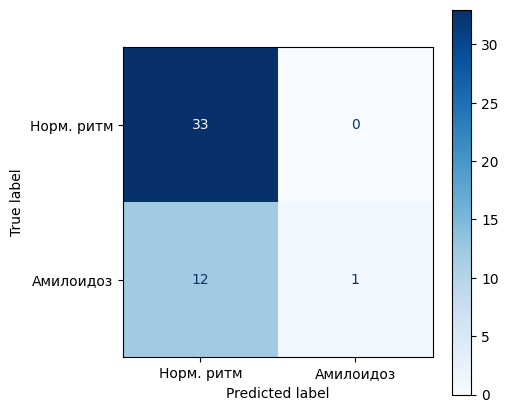

In [15]:
# Создание нескольких классификаторов
rf = RandomForestClassifier(criterion='log_loss')
svm = SVC(probability=True)
# Добавим классификаторы в ансамбль
voting_clf = VotingClassifier(estimators=[('rf', rf), ('svm', svm)], voting='soft')

# Обучение ансамбля
voting_clf.fit(X_train, y_train)

# Оценка точности
y_pred_voting = voting_clf.predict(X_test)
print(f"Voting accuracy: {accuracy_score(y_test, y_pred_voting)}")

# Замените названия классов на соответствующие вам
class_names = ['Норм. ритм', 'Амилоидоз']

print ('\n clasification report:\n', classification_report(y_test, y_pred_voting))

print('Матрица несоответствий для тестовой выборки метода ЛДА:\n')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_voting), display_labels= class_names)
disp.plot(cmap = 'Blues', ax=ax)


In [26]:
signal_len = dgen.signal_len
normalize = dgen.normalize

def calcGroupTable(model, groupnames : list, records : list, label : int, df : pd.DataFrame, metadata):
    for i in range(len(groupnames)):
        record = records[i]
#        y_pred = model.predict(pd.DataFrame({**extract_statistical_features(parts), **extract_frequency_features(parts), **extract_wavelet_features(parts)}))
#        y_weighted = np.asarray(y_pred).sum() / len(y_pred)

#        y_weighted = round(y_weighted) 
        features = ft.extract_features([record], [metadata[i]])
        features = features.fillna(0)
        y_pred = model.predict(features)
        y_pred = int(y_pred[0])

        df.loc[-1] = [groupnames[i], y_pred, label]
        df.index = df.index + 1
        df = df.sort_index()
    return df

In [27]:
# There are two classes. 0 - norm, 1 - amy

pred_tab = pd.DataFrame(columns=["name", "weighted_predict", "label"])

norm_names = os.listdir(dgen.norm_path)
amy_names = os.listdir(dgen.amy_path)
amyc_names = os.listdir(dgen.amyc_path)

norm_names = [name[:6] + "_norm" + name[6:] for name in norm_names]

pred_tab = calcGroupTable(voting_clf, norm_names, norm, 0, pred_tab, norm_h)
pred_tab = calcGroupTable(voting_clf, amyc_names, amyc, 0, pred_tab, amyc_h)
pred_tab = calcGroupTable(voting_clf, amy_names, amy, 1, pred_tab, amy_h)


pred_tab.head(5)

pred_tab.to_csv("voted_result.csv", index=False)